In [1]:
import collections
import pathlib
import random
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
import csv

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
image_to_palette = collections.defaultdict(set)

with open("/home/frostman/work_stuff/image_colorization/trial_data/data.tsv", 'r') as tsvfile:
    for line in tsvfile:
        # print(line.strip().split('\t')) # ['uid', 'url', 'media_path', 'description', 'comments', 'tags', 'color_palette', 'likes', 'saves', 'date', 'collection_time', 'write_date']
        media_path, color_palette  = line.strip().split('\t')
        media_filename = media_path.split('/')[-1]
        image_to_palette[media_filename] = set(color_palette[:].split(','))
image_to_palette

defaultdict(set,
            {'1.png': {'#1F474D',
              '#266E6E',
              '#C9A1AA',
              '#D1C0AA',
              '#E6C4D1',
              '#F5E4E8'},
             '2.png': {'#2F4A57',
              '#3A5E48',
              '#4F788D',
              '#7BA6B4',
              '#A5BFC5',
              '#E87F4D'},
             '3.png': {'#79BBCA',
              '#94C7CF',
              '#C1DCDD',
              '#DC9DA5',
              '#E0EAE4',
              '#E8C6CB'},
             '4.png': {'#5A3439',
              '#60958B',
              '#8EB19C',
              '#A75037',
              '#DB9C77',
              '#E2D3D5'},
             '5.png': {'#332B18',
              '#802C31',
              '#C43B31',
              '#F26646',
              '#FFB870',
              '#FFF2A1'}})

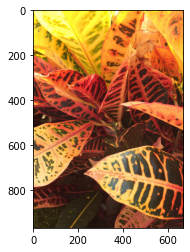

(1, 6, 3)


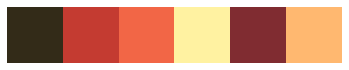

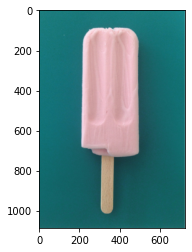

(1, 6, 3)


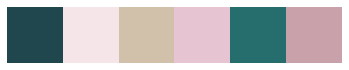

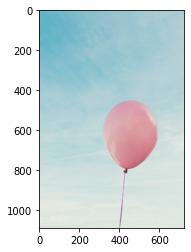

(1, 6, 3)


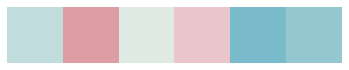

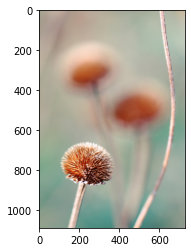

(1, 6, 3)


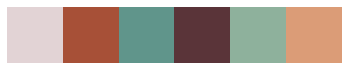

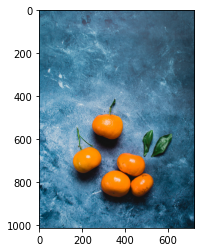

(1, 6, 3)


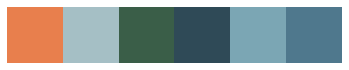

In [3]:
# Visualize the image
# Visualize color palette

def viz_color_palette(hexcodes):
    """
    visualize color palette
    """
    hexcodes = list(hexcodes)
    while len(hexcodes) < 6:
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6]
    
    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette


def viz_image(path, image_to_palette: Dict):
    """
    visualize image
    visualize palette (using image_to_palette)
    """
    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])
    
    # visualize image
    plt.imshow(img)
    plt.show()
    
    # visualize color palette
    print(palette.shape)
    plt.imshow(palette)
    plt.axis('off')
    plt.show()

    return


pathlist = pathlib.Path("/home/frostman/work_stuff/image_colorization/trial_data").glob("*.png")
for path in pathlist:
    viz_image(path, image_to_palette)
    
    

0


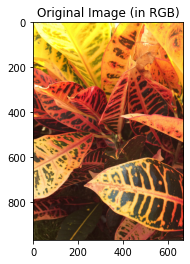

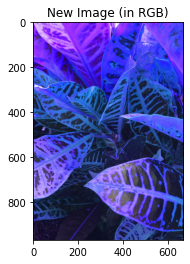

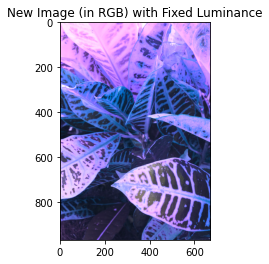

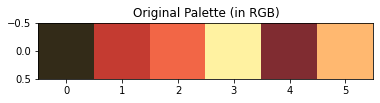

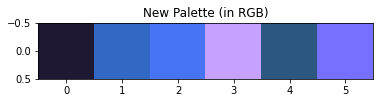

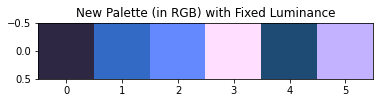

1


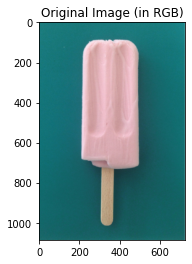

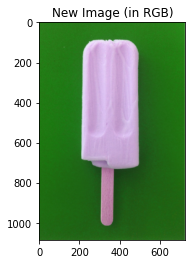

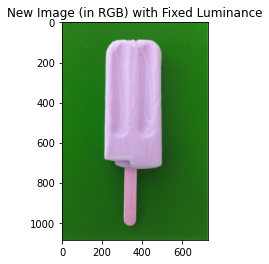

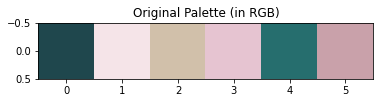

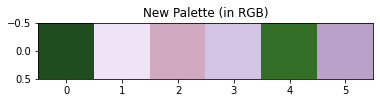

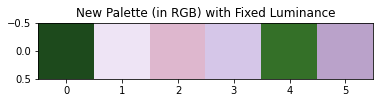

2


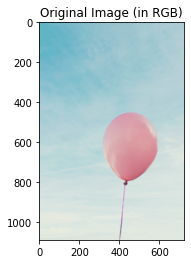

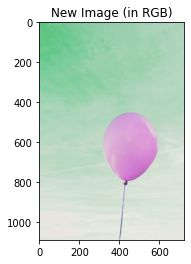

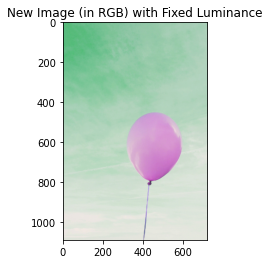

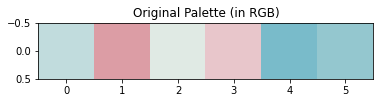

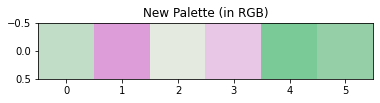

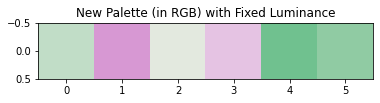

3


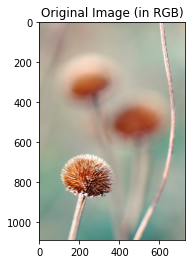

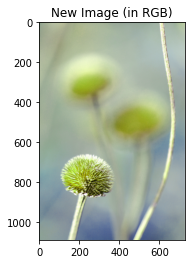

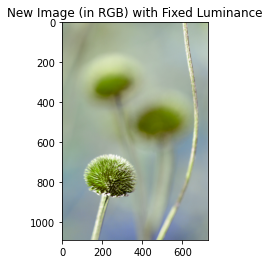

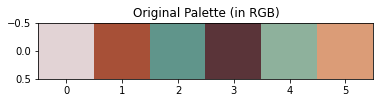

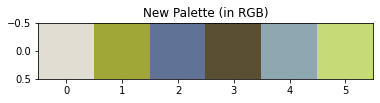

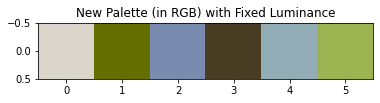

4


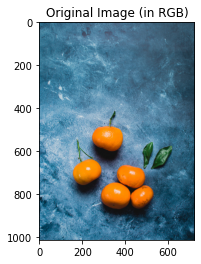

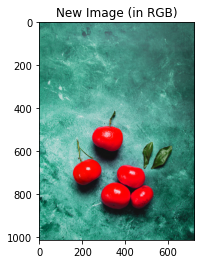

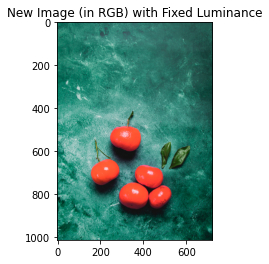

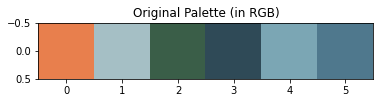

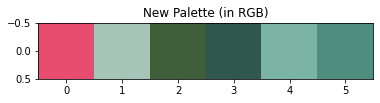

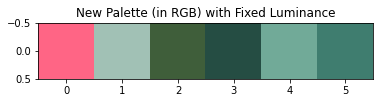

In [13]:
# Generate augmented images for training
#    - input/: images with original palette
#    - output/: images with new palette
#    - old_palette/: pickled files of original palette 
#    - new_palette/: pickled files of new palette 

def augment_image(img, title, hue_shift):
    plt.imshow(img)
    plt.title(f"Original {title} (in RGB)")
    plt.show()

    # RGB -> HSV -> hue-shift 
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1

    new_img = matplotlib.colors.hsv_to_rgb(img_HSV).astype(int)
    plt.imshow(new_img)
    plt.title(f"New {title} (in RGB)")
    plt.show()

    # Fixed original luminance
    img = img.astype(np.float) / 255.0
    new_img = new_img.astype(np.float) / 255.0
    ori_img_LAB = rgb2lab(img)
    new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    new_img_augmented = (lab2rgb(new_img_LAB)*255.0).astype(int)
    plt.imshow(new_img_augmented)
    plt.title(f"New {title} (in RGB) with Fixed Luminance")
    plt.show()
    plt.close()

    return new_img_augmented

pathlist = pathlib.Path("/home/frostman/work_stuff/image_colorization/trial_data").glob("*.png")
for i, path in enumerate(pathlist):
    print(i)
    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])

    hue_shift = random.random()
    augmented_image = augment_image(img, "Image", hue_shift)
    augmented_palette = augment_image(palette, "Palette", hue_shift)

    cv2.imwrite(f'/home/frostman/work_stuff/image_colorization/data/train/input/{path.name}', img)
    pickle.dump(palette, open(f'/home/frostman/work_stuff/image_colorization/data/train/old_palette/{path.stem}.pkl', 'wb'))
    cv2.imwrite(f'/home/frostman/work_stuff/image_colorization/data/train/output/{path.name}', augmented_image)
    pickle.dump(augmented_palette, open(f'/home/frostman/work_stuff/image_colorization/data/train/new_palette/{path.stem}.pkl', 'wb'))

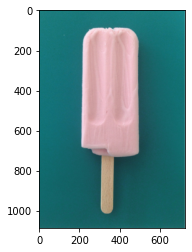

In [14]:
image = cv2.imread("/home/frostman/work_stuff/image_colorization/data/train/input/1.png")
plt.imshow(image)
plt.show()


In [15]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)
    
    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        c3 = self.res1(c4)
        c2 = self.res2(c3)
        c1 = self.res3(c2)
        return c1, c2, c3, c4

In [16]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    )   

class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up_4 = double_conv(18 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(18 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(18 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1) 
        
        
    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        x = self.dconv_up_4(x)
        x = self.upsample(x)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        x = self.dconv_up_3(x)
        x = self.upsample(x)   

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c3, x], dim=1)      
        x = self.dconv_up_2(x)
        x = self.upsample(x)  

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 18, h, w).float().to(device)
        target_palettes = target_palettes.reshape(h, w, bz * 18) * target_palettes_1d
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 18, h, w)
        x = torch.cat([target_palettes.float(), c4, x], dim=1) 
        x = self.dconv_up_1(x)
        x = self.upsample(x)  
        illu = illu.view(illu.size(0), 1, illu.size(1), illu.size(2))
        x = torch.cat((x, illu), dim = 1)
        x = self.conv_last(x)
        return x

In [17]:
from torch.utils.data import Dataset, DataLoader
import pathlib

def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    img = img.permute(1, 2, 0)  # (h, w, channel) 
    img = img.numpy()
    img = img.astype(np.float) / 255.0
    img_LAB = rgb2lab(img)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    return torch.from_numpy(img_L)

class ColorTransferDataset(Dataset):
    def __init__(self, data_folder, transform):
        super().__init__()
        self.data_folder = data_folder
        self.transform = transform

    def __len__(self):
        output_folder = self.data_folder/"output"
        return len(list(output_folder.glob("*")))

    def __getitem__(self, idx):
        input_img_folder = self.data_folder/"input"
        old_palette = self.data_folder/"old_palette"
        new_palette = self.data_folder/"new_palette"
        output_img_folder = self.data_folder/"output"
        files = list(output_img_folder.glob("*"))

        f = files[idx]
        ori_image = transform(cv2.imread(str(input_img_folder/f.name)))
        new_image = transform(cv2.imread(str(output_img_folder/f.name)))
        illu = get_illuminance(ori_image)

        new_palette = pickle.load(open(str(new_palette/f.stem) +'.pkl', 'rb'))
        new_palette = new_palette[:, :6, :].ravel() / 255.0

        old_palette = pickle.load(open(str(old_palette/f.stem) +'.pkl', 'rb'))
        old_palette = old_palette[:, :6, :].ravel() / 255.0

        ori_image = ori_image.double()
        new_image = new_image.double()
        illu = illu.double()
        new_palette = torch.from_numpy(new_palette).double()
        old_palette = torch.from_numpy(old_palette).double()

        return ori_image, new_image, illu, new_palette, old_palette

def viz_color_palette(hexcodes):
    """
    visualize color palette
    """
    hexcodes = list(hexcodes)
    while len(hexcodes) < 6:
        hexcodes = hexcodes + hexcodes
    hexcodes = hexcodes[:6]
    
    palette = []
    for hexcode in hexcodes:
        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        palette.append(rgb)

    palette = np.array(palette)[np.newaxis, :, :]
    return palette

def viz_image_ori_new_out(ori, palette, new, out):
    """
    visualize original image, input palette, true new image, and output image from the model. 
    """
    ori = ori.detach().cpu().numpy()
    new = new.detach().cpu().numpy()
    out = out.detach().cpu().numpy()
    palette = palette.detach().cpu().numpy()

    plt.imshow(np.transpose(ori, (1,2,0)), interpolation='nearest')
    plt.title("Original Image")
    plt.show()

    palette = palette.reshape((1, 6, 3))
    plt.imshow(palette, interpolation='nearest')
    plt.title("Palette")
    plt.show()

    # plt.imshow((np.transpose(out, (1,2,0)) * 255).astype(np.uint8))
    plt.imshow((np.transpose(out, (1,2,0))))
    plt.title("Output Image")
    plt.show()

    plt.imshow(np.transpose(new, (1,2,0)), interpolation='nearest')
    plt.title("True Image")
    plt.show()

In [20]:
bz = 16
epoches = 100
lr = 0.0002

# pre-processsing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((432, 288)),
    transforms.ToTensor(),
])


# dataset and dataloader
train_data = ColorTransferDataset(pathlib.Path("//home/frostman/work_stuff/image_colorization/data/train"), transform)
train_loader = DataLoader(train_data, batch_size=bz)

# create model, criterion and optimzer
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=lr, weight_decay=4e-3)

In [21]:
# train FE and RD
min_loss = float('inf')
for e in range(epoches):
    total_loss = 0.
    for i_batch, sampled_batched in enumerate(tqdm(train_loader)):
        ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
        palette = new_palette.flatten()
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))

        optimizer.zero_grad()
        loss = criterion(out, new_image.float().to(device))
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    print(e, total_loss)

    if total_loss < min_loss:
        min_loss = total_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, "/home/frostman/work_stuff/image_colorization/saved_model/FE_RD.pth")

  0%|          | 0/1 [00:00<?, ?it/s]

0 0.6938286423683167


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


1 0.5685849785804749


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


2 0.39453667402267456


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


3 0.3673388659954071


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


4 0.3503307104110718


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


5 0.34324225783348083


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


6 0.33763977885246277


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


7 0.33369573950767517


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


8 0.33080413937568665


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


9 0.32741469144821167


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


10 0.3246639668941498


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


11 0.3231826424598694


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


12 0.32167479395866394


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


13 0.31956496834754944


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


14 0.3176248073577881


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


15 0.31633317470550537


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


16 0.315393328666687


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


17 0.31436145305633545


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


18 0.3130679726600647


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


19 0.3116690218448639


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


20 0.31048524379730225


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


21 0.30961257219314575


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


22 0.30875295400619507


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


23 0.3076361417770386


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


24 0.3064135015010834


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


25 0.30537402629852295


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


26 0.3044920265674591


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


27 0.3035333752632141


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


28 0.3024589419364929


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


29 0.30142417550086975


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


30 0.30046167969703674


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


31 0.2994609475135803


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


32 0.2984146475791931


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


33 0.29740771651268005


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


34 0.29641759395599365


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


35 0.29535457491874695


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


36 0.29424330592155457


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


37 0.2931812107563019


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


38 0.292158842086792


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


39 0.29108139872550964


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


40 0.2899349629878998


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


41 0.28878679871559143


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


42 0.2876608371734619


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


43 0.2865216135978699


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


44 0.28534170985221863


100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


45 0.28412535786628723


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


46 0.28289541602134705


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


47 0.28166186809539795


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


48 0.28039827942848206


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


49 0.2790876626968384


  0%|          | 0/1 [00:00<?, ?it/s]

50 0.27775678038597107


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


51 0.2764166295528412


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


52 0.2750436067581177


  0%|          | 0/1 [00:00<?, ?it/s]

53 0.2736402750015259


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


54 0.2722170054912567


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


55 0.2707573175430298


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


56 0.2692657709121704


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


57 0.26774725317955017


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


58 0.2661815285682678


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


59 0.26458728313446045


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


60 0.26295870542526245


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


61 0.2612745761871338


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


62 0.25956499576568604


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


63 0.25780782103538513


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


64 0.25600913166999817


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


65 0.2541843056678772


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


66 0.2523277699947357


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


67 0.2504361569881439


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


68 0.24852658808231354


100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


69 0.24659086763858795


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


70 0.24462880194187164


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


71 0.24263779819011688


  0%|          | 0/1 [00:00<?, ?it/s]

72 0.24062010645866394


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


73 0.23857073485851288


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


74 0.23649558424949646


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


75 0.23440243303775787


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


76 0.23229068517684937


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


77 0.23016637563705444


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


78 0.2280280739068985


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


79 0.22587597370147705


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


80 0.22371819615364075


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


81 0.221551313996315


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


82 0.21938185393810272


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


83 0.2172103226184845


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


84 0.21503989398479462


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


85 0.212869793176651


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


86 0.2107018381357193


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


87 0.20853112637996674


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


88 0.20636361837387085


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


89 0.20420652627944946


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


90 0.20208467543125153


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


91 0.20008380711078644


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


92 0.19856081902980804


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


93 0.19847309589385986


  0%|          | 0/1 [00:00<?, ?it/s]

94 0.19938290119171143


  0%|          | 0/1 [00:00<?, ?it/s]

95 0.19665446877479553


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


96 0.18969319760799408


  0%|          | 0/1 [00:00<?, ?it/s]

97 0.190034881234169


  0%|          | 0/1 [00:00<?, ?it/s]

98 0.18880218267440796


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


99 0.1835745871067047


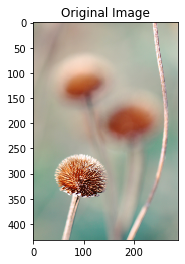

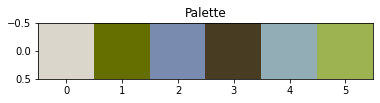

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


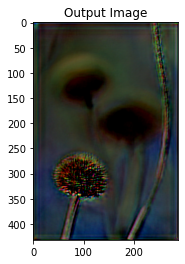

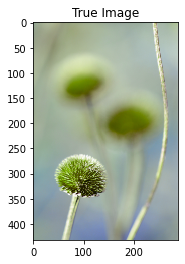

In [37]:
# load model from saved model file
state = torch.load("/home/frostman/work_stuff/image_colorization/saved_model/FE_RD.pth")
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

for i_batch, sampled_batched in enumerate(train_loader):
    ori_image, new_image, illu, new_palette, ori_palette = sampled_batched
    flat_palette = new_palette.flatten()
    c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
    out = RD.forward(c1, c2, c3, c4, flat_palette.float().to(device), illu.float().to(device))
    break

idx = 3
viz_image_ori_new_out(ori_image[idx], new_palette[idx], new_image[idx], out[idx])